# Stock characteristic

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns

import warnings

from lob_data_utils import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from stocks from 2013-09 - 2013-11. The market is open between 8-16 on weekdays, so we use the data from 9-15 to avoid having data affected by the abnormal trading behaviour, which usually occurs right after opening or closing auction. The tick size is $\pi = 0.01$ for the market, but the *relative tick size*(the ratio between stock price and $\pi$) for each stock differs.

To each stock data we introduce:

* bid price: $$ b(t) := \underset{\{x \in bidList(t) \}}{\max} x.price $$
* ask price: $$ a(t) := \underset{\{x \in askList(t)\}}{\min} x.price $$

* total size of active buy orders: $$ n^{b}(p, t) = \sum_{\{x \in buyList(t), p_x = p\}} x.volumen $$

* total size of active sell orders: $$ n^{a}(p, t) = \sum_{\{x \in askList(t), p_x = p\}} x.volumen $$


* mid price: $$ m(t) := \frac{a(t) + b(t)}{2} $$

* queue imbalance: $$ I(t) := \frac{n^b (b_t , t) - n^a (a_t, t)}{n^b (b_t , t) + n^a (a_t, t)} $$ where $a_t$ and $b_t$ are ask and bid prices for time $t$ respectively.

* mid price indicator: $$ y_i = \begin{cases} 1 & \text{if} & m(t_i) > m(t_{i-1})\\ 0 & \text{if} & m(t_i) < m(t_{i-1})\\ \end{cases} $$

Based on the **queue imbalance** we will try to predict **mid price indicator**

In [2]:
from lob_data_utils.roc_results import results

df_roc = pd.DataFrame()
df_roc['stock'] = results.keys()
df_roc['roc_area'] = results.values()

df_roc = df_roc.sort_values(by='roc_area', ascending=False)

dfs = {}
dfs_test = {}

stocks = df_roc['stock'].values

for s in stocks:
    d, d_test = lob.load_prepared_data(s, length=None)
    dfs[s] = d
    dfs_test[s] = d_test

In [3]:
df_roc = pd.DataFrame()
df_roc['stock'] = [s for s in results.keys() if s in stocks]
df_roc['roc_area'] = [results[s] for s in results.keys() if s in stocks]
df_roc = df_roc.sort_values(by='roc_area', ascending=False)
df_roc.head()

,stock,roc_area
94,2028,0.616323
62,2197,0.614852
26,12098,0.611904
64,12552,0.611180
16,1221,0.610522


### Description of DataFrame

The data is indexed with time $t$.

* `bid` - bid queue
* `ask` - ask queue
* `bid_price` - bid price $b(t)$
* `ask_price` - ask price $a(t)$
* `mid_price` - mid price $m(t)$
* `sum_sell_ask` - total size of active sell orders for ask price  $ n^{a}(a(t), t) $
* `sum_buy_bid` - total size of active buy orders for bid price  $ n^{b}(b(t), t) $
* `mid_price_indicator` - the indicator if the mid price will rise in the **next** time tick
* `queue_imbalance` - $I(t)$

### Stock characteristic

We are looking for some metric which will help us determine which SVM kernel will work the best for each stock.

We introduce metrics:

* sum_sell_ask_mean
* sum_buy_bid_mean
* diff_mean_bid_ask
* max_trade_price
* min_trade_price
* diff_trade_price
* bid_ask_spread
* max_len_ask
* max_len_bid
* spread_by_price

In [4]:
df_summary = lob.prepare_summary(stocks, dfs)
df_summary['spread_by_price'] = df_summary['bid_ask_spread'] / df_summary['diff_trade_price']

KeyError: 'diff_trade_price'

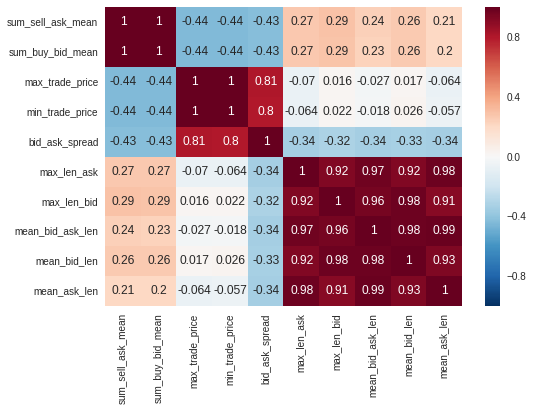

In [5]:
sns.heatmap(df_summary.corr(), annot=True)

In [6]:
df_by_len = df_summary.sort_values(by='len_bid')
df_by_len.head()

KeyError: 'len_bid'

NameError: name 'df_by_len' is not defined

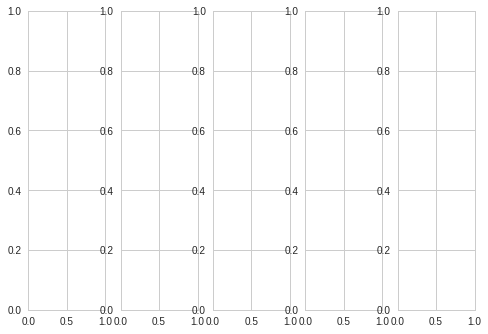

In [7]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    sns.violinplot(x='mid_price_indicator', 
               y='queue_imbalance', data=dfs[plot_stocks[i]], split=False, ax=axs[i],
                  label=plot_stocks[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    sns.violinplot(x='mid_price_indicator', 
               y='queue_imbalance', data=dfs[plot_stocks[i]], split=False, ax=axs[i],
                  label=plot_stocks[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [8]:
n = 5
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    sns.jointplot("mid_price", "queue_imbalance", data=dfs[plot_stocks[i]], 
                  kind='kde')
    plt.title(str(plot_stocks[i]))

plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    sns.jointplot("mid_price", "queue_imbalance", data=dfs[plot_stocks[i]], 
                  kind='kde')
    plt.title(str(plot_stocks[i]))
#     sns.jointplot(x="mid_price", y="queue_imbalance", 
#               data=df.loc[:, ['mid_price', 'queue_imbalance']], kind="kde")

NameError: name 'df_by_len' is not defined

In [ ]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    print(axs[i])
    axs[i].hist(x = [df[df['mid_price_indicator']==1]['queue_imbalance'], 
                  df[df['mid_price_indicator']==0]['queue_imbalance']],
             stacked=True, label = ['will raise', 'will not raise'])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    axs[i].hist(x = [df[df['mid_price_indicator']==1]['queue_imbalance'], 
                  df[df['mid_price_indicator']==0]['queue_imbalance']],
             stacked=True, label = ['will raise', 'will not raise'])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)




In [ ]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    # df['mid_price'].plot('kde', ax=axs[i])
    df['queue_imbalance'].plot('kde', ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    # df['mid_price'].plot('kde', ax=axs[i])
    df['queue_imbalance'].plot('kde', ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [ ]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    sns.barplot(x = 'mid_price_indicator', y = 'queue_imbalance', data=df, ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    sns.barplot(x = 'mid_price_indicator', y = 'queue_imbalance', data=df, ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

## Clustering data with all features

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit_predict(df_summary)

In [ ]:
df_summary['class']= kmeans

In [ ]:
sns.heatmap(df_summary.corr(), annot=True)